# **INPUT-TARGET PAIRS**
In this section, we implement a data loader that fetches the input-target pairs using a sliding window approach

To get started, we will first tokenize the whole verdict short story using BPE tokenizer.

In [10]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

with open('the-verdict.txt','r',encoding="utf-8") as f:
  raw_text = f.read()
enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

5145


5145 Tokens after applying byte pair encoding.


In [11]:
enc_sample = enc_text[50:]

One of the easiest intuitive ways to create the input-target pairs for the nextword prediction task is to two variables x, y . x- input tokens ,y - target which is essentially input shifted by 1 .

In [12]:
context_size = 4 # Length of the input
#The context_size of 4 means that the model is trained to look at sequence of 4 words to predict the next word in sequence.
x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]
print(f"x:{x}")
print(f"y:     {y}")

x:[290, 4920, 2241, 287]
y:     [4920, 2241, 287, 257]


Processing the inputs along with the targets, which are the inputs shifted by one position, we can then create the next-word prediction tasks as follows.

In [5]:
for i in range(1, context_size + 1):
  context = enc_sample[:i]
  desired = enc_sample[i]
  print(context,"----->",desired)

[290] -----> 4920
[290, 4920] -----> 2241
[290, 4920, 2241] -----> 287
[290, 4920, 2241, 287] -----> 257


Everything left of the arrow (---->) refers to the input an LLM would receive, and the token ID on the right side is the one LLM is supposed to predict.

Previous code , converting token ID to text.

In [15]:
for i in range(1,context_size+1):
  context = enc_sample[:i]
  desired = enc_sample[i]
  print(tokenizer.decode(context),"----->",tokenizer.decode([desired]))

 and ----->  established
 and established ----->  himself
 and established himself ----->  in
 and established himself in ----->  a


We have not created the input-target pairs that we can turn into use for the LLM training in upcoming chapters.

For efficient data loading , we create input and target as pytorch tensors, which can be thought of multi dimensional array.
Two tensors , input tensor containing the text that the LLM sees and a target tensor for LLM to predict.

**IMPLEMENTING A DATA LOADER**

For the efficient data loader implementation, we will use pytorch's built in dataset and dataloader classes.

Step 1 : Tokenize the entire text.

Step 2 : Use a sliding window to chunk the book into overlapping sequences of max_length

Step 3: Return the total number of rows in the dataset.

Step 4 :Return a single row from the dataset.

In [21]:
from torch.utils.data import Dataset,DataLoader

class GPTDatasetV1(Dataset):
  def __init__(self,txt,tokenizer,max_length,stride):
    self.input_ids = []
    self.target_ids = []

    token_ids = tokenizer.encode(txt,allowed_special={"<|endoftext|>"})

    for i in range(0,len(token_ids)-max_length,stride):
      input_chunk = token_ids[i:i+max_length]
      target_chunk = token_ids[i+1:i+max_length+1]
      self.input_ids.append(torch.tensor(input_chunk))
      self.target_ids.append(torch.tensor(target_chunk))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx],self.target_ids[idx]


Reason for using __getitem__
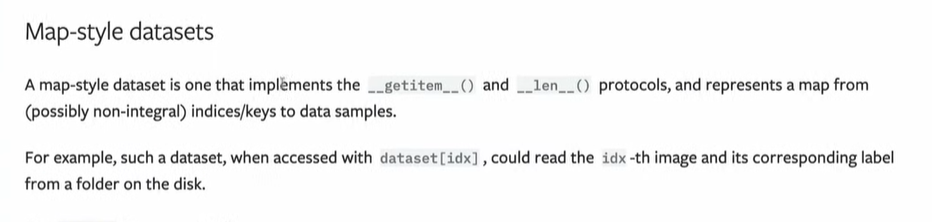

The GPTDatasetV1 class above is based on the Pytorch Dataset class.
It defines how individual rows are fetched from the dataset.

Each row consists of a number of tokenID's (based on a max_length) assigned to an input_chunk tensor.

The target_chunk tensor contains the corresponding targets.


The following code will use the GPTDatasetV1 to load the inputs in batches via a PyTorch dataloader.

Step1 : Initialize the token.

Step2 : Create dataset.

Step3 : drop_last = True drops the last batch if it is shorter than the specified batch_size to prevent loss spikes during training.

Step4 : The number of CPU processes to use for preprocessing.

In [18]:
def create_dataloader_v1(txt,batch_size=4, max_length=256,stride=128,shuffle=True,drop_last=True,num_workers=0):
  # Initialize the tokenizer
  tokenizer = tiktoken.get_encoding('gpt2')

  #Create Dataset
  dataset = GPTDatasetV1(txt,tokenizer,max_length,stride)

  #Create dataloader
  dataloader = DataLoader(dataset, batch_size = batch_size,shuffle=shuffle,drop_last=drop_last,num_workers=num_workers)

  return dataloader

Let's test the dataloader with a batchsize of 1 for an LLM with a context length of 4.
This will develop an intuition of how the GPTDatasetV1 class and the create_dataloader_v1 function work together.

In [19]:
with open("the-verdict.txt","r",encoding="utf-8") as f:
  raw_text = f.read()

Convert dataloader into a python iterator to fetch the next entry via Python's built-in next() function.

In [22]:
import torch
dataloader = create_dataloader_v1(raw_text,batch_size=1,max_length=4,stride=1,shuffle=False)
data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


The first_batch vairable contains two tensors : the first tensor stores the input token ID's and the second tensor stores the target token IDs.

Since the max_length is set to 4, each of the two tensors contains 4 token ID's

Note that an input size of 4 is relatively small and only chosen for illustration purposes. It is common to train LLMs with input sizes of atleast 256.

In [23]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


Batch size of 1, such as we have sampled from the data loader so far , are useful for illustration purposes.
In general experience with deep learning, you may know that small batch sizes require less memory during training but lead to more noise.
Just like in regular deep learning, the batch size is a trafe-off and hyper parameter to experiment with when training LLM's

Dataloader with batch size more than 1

In [24]:
dataloader = create_dataloader_v1(raw_text,batch_size=8,max_length=4,stride=4,shuffle=False)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs\n",inputs)
print("\nTargets:\n",targets)

Inputs
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


Note that we increased the stride to 4. This is to utilize the dataset fully (we don't skip a single word) but also avoid any overlap between the batches,nuch that overlap could lead to increased overfitting.